In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import math
import scipy
import requests
import warnings
import h5py
import fsspec
from pyproj import Proj, CRS
import pysolid
import pymap3d as pm   #for transformation between ENU and llh

import matplotlib.pyplot as plt

from isce3.core import Ellipsoid as ellips

from osgeo import gdal, osr

import shapely.wkt as wkt
from shapely import geometry

from src.ALE_utils import oversample_slc, get_snr_peak, findCR, en2rdr
import os
import timeit
warnings.filterwarnings('ignore')

In [2]:
# Start runtime evaluation
start = timeit.default_timer()

In [3]:
# Parameters for papermill
cslc_url = 's3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_L2_CSLC-S1A_IW_T064-135523-IW2_VV_20220817T015056Z_v0.0_20230527T133501Z/OPERA_L2_CSLC-S1A_IW_T064-135523-IW2_VV_20220817T015056Z_v0.0_20230527T133501Z.h5'
cslc_static_url = 's3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_L2_CSLC-S1A_IW_T064-135523-IW2_VV_20220817T015056Z_v0.0_20230527T133501Z_static_layers/OPERA_L2_CSLC-S1A_IW_T064-135523-IW2_VV_20220817T015056Z_v0.0_20230527T133501Z_static_layers.h5'
save_dir = 'Rosamond'
burst_id = 't064_135523_iw2'
date = '20220817'
snr_threshold = 15
solidtide = 'True'
cr_network = 'Rosamond'
ovsFactor = 64

In [4]:
pol = 'VV'
s3f = fsspec.open(cslc_url, mode='rb', anon=True, default_fill_cache=False)

# Load the CSLC and necessary metadata
DATA_ROOT = 'science/SENTINEL1'
grid_path = f'{DATA_ROOT}/CSLC/grids'
static_grid_path = f'{DATA_ROOT}/CSLC/grids/static_layers'
metadata_path = f'metadata'
burstmetadata_path = f'{DATA_ROOT}/CSLC/metadata/processing_information/s1_burst_metadata'
id_path = f'{DATA_ROOT}/identification'

with h5py.File(s3f.open(),'r') as h5:
    cslc = h5[f'{grid_path}/{pol}'][:]
    xcoor = h5[f'{grid_path}/x_coordinates'][:]
    ycoor = h5[f'{grid_path}/y_coordinates'][:]
    dx = h5[f'{grid_path}/x_spacing'][()].astype(int)
    dy = h5[f'{grid_path}/y_spacing'][()].astype(int)
    epsg = h5[f'{grid_path}/projection'][()].astype(int)
    sensing_start = h5[f'{burstmetadata_path}/sensing_start'][()].astype(str)
    sensing_stop = h5[f'{burstmetadata_path}/sensing_stop'][()].astype(str)
    dims = h5[f'{burstmetadata_path}/shape'][:]
    bounding_polygon = h5[f'{id_path}/bounding_polygon'][()].astype(str) 
    orbit_direction = h5[f'{id_path}/orbit_pass_direction'][()].astype(str)
    center_lon, center_lat = h5[f'{burstmetadata_path}/center']
    
# Get bounding box
cslc_poly = wkt.loads(bounding_polygon)

In [5]:
# Check if the CR data already exists
if os.path.exists(f'{save_dir}/crdata/crdata_{date}.csv') == False and cr_network=='Rosamond':
    # Get the cslc date
    date_ = dt.datetime.strptime(sensing_start.astype(str),'%Y-%m-%d %H:%M:%S.%f').strftime('%Y-%m-%d+%H\u0021%M')

    # Download corner reflector data from UAVSAR/NISAR based on the date of the CSLC product
    res = requests.get(f'https://uavsar.jpl.nasa.gov/cgi-bin/corner-reflectors.pl?date={str(date_)}&project=uavsar')
    open(f'{save_dir}/crdata/crdata_{date}.csv', 'wb').write(res.content)

elif os.path.exists(f'{save_dir}/crdata/crdata_{date}.csv') == False and cr_network=='Oklahoma':
    # Get the cslc date
    date_ = dt.datetime.strptime(sensing_start.astype(str),'%Y-%m-%d %H:%M:%S.%f').strftime('%Y-%m-%d+%H\u0021%M')
    
    # Download corner reflector data from UAVSAR/NISAR based on the date of the CSLC product
    res = requests.get(f'https://uavsar.jpl.nasa.gov/cgi-bin/corner-reflectors.pl?date={str(date_)}&project=nisar')
    open(f'{save_dir}/crdata/crdata_{date}.csv', 'wb').write(res.content)

elif os.path.exists(f'{save_dir}/crdata/crdata_{date}.csv') == False and cr_network=='Alaska':
    # Get the cslc date
    date_ = dt.datetime.strptime(sensing_start.astype(str),'%Y-%m-%d %H:%M:%S.%f').strftime('%Y-%m-%d+%H\u0021%M')

    # Download corner reflector data from NISAR based on the date of the CSLC product
    res = requests.get(f'https://uavsar.jpl.nasa.gov/cgi-bin/corner-reflectors.pl?date={str(date_)}&project=alaska')
    open(f'crdata_{date}.csv', 'wb').write(res.content)

else:
    print(f'Corner Reflector Data: crdata_{date}.csv already exists. Skipping download.')

# Read to pandas dataframe and rename columns
df = pd.read_csv(f'{save_dir}/crdata/crdata_{date}.csv')
df.rename(columns={'Corner reflector ID':'ID'}, inplace=True)
df.rename(columns={'Latitude (deg)':'lat'}, inplace=True) 
df.rename(columns={'Longitude (deg)':'lon'}, inplace=True) 
df.rename(columns={'Azimuth (deg)':'azm'}, inplace=True)
df.rename(columns={'Tilt / Elevation angle (deg)':'tilt'}, inplace=True)
df.rename(columns={'Height above ellipsoid (m)':'hgt'}, inplace=True) 
df.rename(columns={'Side length (m)':'slen'}, inplace=True)
df.slen = np.round(df.slen,1)
df.head()

Corner Reflector Data: crdata_20230414.csv already exists. Skipping download.


,ID,lat,lon,hgt,azm,tilt,slen
0,0,34.796969,-118.096531,660.8010,170.5,12.10,2.4
1,1,34.799849,-118.086989,661.0355,170.5,8.72,2.4
2,2,34.805238,-118.087389,660.8112,168.5,8.70,2.4
3,3,34.805338,-118.081945,661.0072,170.0,8.63,2.4
4,4,34.805416,-118.076378,661.1700,176.0,11.93,2.4


In [6]:
if (solidtide == 'True' ):
    #solid earth tide correction with PySolid
    dateformat = '%Y-%m-%d %H:%M:%S.%f'  #date format of input azimuth time
    dt0 = dt.datetime.strptime(sensing_start,dateformat)
    dt1 = dt.datetime.strptime(sensing_stop,dateformat)
    step_sec = 5                        # sample spacing in time domain in seconds

    for idx, row in df.iterrows():

        llh = [np.deg2rad(row['lon']), np.deg2rad(row['lat']), row['hgt']]  #lon/lat/hgt

        _elp = ellips()
        xyz = _elp.lon_lat_to_xyz(llh) #xyz coordinate of CR

        # compute SET via pysolid
        (dt_out,
         tide_e,
         tide_n,
         tide_u) = pysolid.calc_solid_earth_tides_point(np.rad2deg(llh[1]), np.rad2deg(llh[0]), dt0, dt1,
                                                    step_sec=step_sec,
                                                    display=False,
                                                    verbose=False)

        tide_e = np.mean(tide_e[0:2])
        tide_n = np.mean(tide_n[0:2])
        tide_u = np.mean(tide_u[0:2])

        #updating lat,lon,hgt after SET correction
        llh = pm.enu2geodetic(tide_e, tide_n, tide_u,np.rad2deg(llh[1]),np.rad2deg(llh[0]),llh[2],deg=True)

        df.loc[idx,'lat'] = llh[0]
        df.loc[idx,'lon'] = llh[1]
        df.loc[idx,'hgt'] = llh[2]   

PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.7969693/-118.09653057999999 degree
PYSOLID: start UTC: 2023-04-14T01:50:54.985771
PYSOLID: end   UTC: 2023-04-14T01:50:58.083494
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.79984858/-118.08698853 degree
PYSOLID: start UTC: 2023-04-14T01:50:54.985771
PYSOLID: end   UTC: 2023-04-14T01:50:58.083494
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.80523756/-118.08738898 degree
PYSOLID: start UTC: 2023-04-14T01:50:54.985771
PYSOLID: end   UTC: 2023-04-14T01:50:58.083494
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.80533836/-118.08194458000001 degree
PYSOLID: start UTC: 2023-04-14T01:50:54.985771
PYSOLID: end   UTC: 2023-04-14T01:50:58.083494
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth ti

In [7]:
if 'lon' not in df.keys():
    raise SystemExit('No CRs found within burst, exit notebook')

In [8]:
# Calculate the locations of CRs in SAR image
UTMx = []
UTMy = []
xloc = []
yloc = []
xloc_float = []
yloc_float = []
_in = []

for idx, row in df.iterrows():
    
    _Proj = Proj(CRS.from_epsg(epsg))
    _x, _y = _Proj(row['lon'], row['lat'],inverse=False)     #conversion of lat/lon of CRs to UTM coordinates
    
    #location of CRs in SLC image
    _xloc = int((_x-xcoor[0])/dx)    
    _yloc = int((_y-ycoor[0])/dy)
    
    UTMx.append(_x) 
    UTMy.append(_y)
    xloc.append(_xloc)
    yloc.append(_yloc)
    xloc_float.append((_x-xcoor[0])/dx)
    yloc_float.append((_y-ycoor[0])/dy)
    _in.append(cslc_poly.contains(geometry.Point(row['lon'], row['lat'])))
    
df['UTMx'] = UTMx
df['UTMy'] = UTMy
df['xloc'] = xloc
df['yloc'] = yloc
df['xloc_float'] = xloc_float
df['yloc_float'] = yloc_float
df['inPoly'] = _in

#checking whether CRs are in SLC coverage. Including only CRs within SLC image
df = df[df['inPoly']==True]
df.drop('inPoly', axis=1, inplace=True)
df = df.reset_index(drop=True)
df.head()

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,yloc,xloc_float,yloc_float
0,1,34.799848,-118.086988,661.189625,170.5,8.72,2.4,400567.498456,3.851386e+06,1462,2995,1462.999691,2995.928662
1,2,34.805237,-118.087389,660.965314,168.5,8.70,2.4,400537.340025,3.851984e+06,1456,2936,1456.968005,2936.125411
2,3,34.805338,-118.081944,661.161324,170.0,8.63,2.4,401035.476685,3.851990e+06,1556,2935,1556.595337,2935.545744
3,4,34.805415,-118.076378,661.324135,176.0,11.93,2.4,401544.757996,3.851993e+06,1658,2935,1658.451599,2935.237750
4,5,34.805494,-118.070803,661.393846,171.0,11.07,2.4,402054.800362,3.851996e+06,1760,2934,1760.460072,2934.915766


In [9]:
# Select CRs according to orbit direction
if cr_network=='Rosamond' or cr_network=='Oklahoma':
    if orbit_direction == 'Ascending':
        df_filter = df[(df['azm']>140) & (df['azm']<220)].reset_index(drop=True)
        #only west-looking CRs (for right-looking ascending)
    else:     #Descending
        df_filter = df[~((df['azm']>140) & (df['azm']<220))].reset_index(drop=True)
        #only east-looking CRs (for right-looking descending)
if cr_network=='Alaska':
    if orbit_direction == 'Ascending':
        # only west-looking CRs (for right-looking ascending)
        df_filter = df.loc[(df['azm']>160) & (df['azm']<200)]
        # reject N32A if data from past 20220601 as it got overturned
        if dt.datetime.strptime('20220601', '%Y%m%d') <= dt.datetime.strptime(str(date), '%Y%m%d'):
            df_filter = df_filter[df_filter['ID']!='N32A'].reset_index(drop=True)
    else:     #Descending
        # only east-looking CRs (for right-looking descending)
        df_filter = df[df['azm']<20].reset_index(drop=True)

df_filter = df_filter.loc[df_filter['slen']>0.8].reset_index(drop=True)   #excluding SWOT CRs (0.7 m as a side length)
df = None

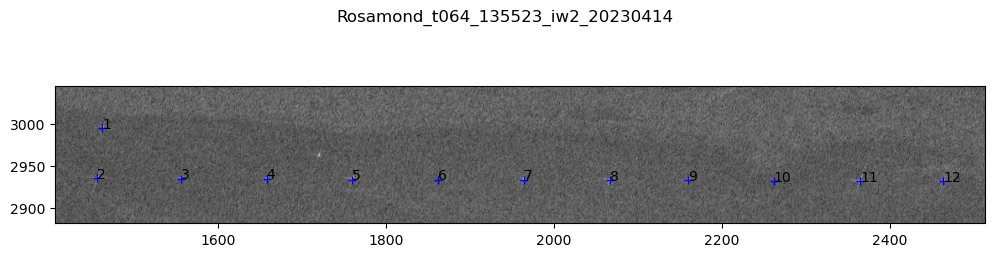

In [10]:
# Displaying SLC image
buffer = 50
minX = df_filter['xloc'].min() - buffer
maxX = df_filter['xloc'].max() + buffer
minY = df_filter['yloc'].min() - buffer
maxY = df_filter['yloc'].max() + buffer

scale_ = 1.0
exp_ = 0.15

fig, ax = plt.subplots(figsize=(12, 3))
cax=ax.imshow(scale_*(np.abs(cslc))**exp_, cmap='gray',interpolation=None, origin='upper')
ax.set_xlim(minX,maxX)
ax.set_ylim(minY,maxY)

for sl in pd.unique(df_filter.slen):
    xx = df_filter.loc[df_filter['slen']==sl]['xloc']
    yy = df_filter.loc[df_filter['slen']==sl]['yloc']
    ID = df_filter.loc[df_filter['slen']==sl]['ID']
    
    if sl == 2.4:
        color='blue'
    elif sl == 4.8:
        color='red'
    elif sl == 2.8:
        color='yellow'
    else:
        color='green'
    
    ax.scatter(xx,yy,color=color,marker="+",lw=1)
    for _ID,_xx,_yy in zip(ID,xx,yy):
        ax.annotate(_ID, (_xx, _yy), fontsize=10)

ax.set_aspect(1)
fig.suptitle(f'{cr_network}_{burst_id}_{date}')
fig.savefig(f'{save_dir}/pngs/S1_CSLC_CRs_{cr_network}_{burst_id}_{date}.png',dpi=300,bbox_inches='tight')

In [11]:
xpeak = []
ypeak = []
snr = []

for ID, xoff, yoff in zip(df_filter['ID'],df_filter['xloc'],df_filter['yloc']):
    # crop a patch of 10*10 with center at the calculated CR position
    pxbuff = 5
    pybuff = 5
    cropcslc = cslc[(yoff-pybuff):(yoff+pybuff),(xoff-pxbuff):(xoff+pxbuff)]
    _snr = get_snr_peak(cropcslc)

    # find the peak amplitude in the 10*10 patch
    yind,xind = np.unravel_index(np.argmax(np.abs(cropcslc), axis=None), cropcslc.shape)
    
    # give a warning if the peak and the calculated postion are too far
    dyind = yind-pybuff; dxind = xind-pxbuff
    dist = math.sqrt(dyind**2+dxind**2)
    if dist > 5.0:
        warnings.warn(f'the most bright pixel and the xloc is too far for CR {ID}')
    
    # crop a patch of 32*32 but with its center at the peak
    xbuff = 32
    ybuff = 32
    ycrop = np.arange(yoff+dyind-ybuff,yoff+dyind+ybuff)
    xcrop = np.arange(xoff+dxind-xbuff,xoff+dxind+xbuff)
    cropcslc = cslc[ycrop,:][:,xcrop]

    # Oversample slc
    cropcslc_ovs,ycrop_ovs,xcrop_ovs = oversample_slc(cropcslc,sampling=ovsFactor,y=ycrop,x=xcrop)

    # find the peak amplitude again in a 2 x 2 patch, it correspond to 
    # (2*ovsFactor) x (2*ovsFactor) in oversampled slc
    yoff2 = int(cropcslc_ovs.shape[0]/2)
    xoff2 = int(cropcslc_ovs.shape[1]/2)
    cropcslc2 = cropcslc_ovs[yoff2-ovsFactor:yoff2+ovsFactor+1,
                           xoff2-ovsFactor:xoff2+ovsFactor+1]
    yind2,xind2 = np.unravel_index(np.argmax(abs(cropcslc2), axis=None), cropcslc2.shape)
    dyind2 = yind2-ovsFactor; dxind2 = xind2-ovsFactor

    # crop a patch of 3x3 oversampled patch with center at the peak
    cropcslc2 = cropcslc_ovs[yoff2+dyind2-1:yoff2+dyind2+2,xoff2+dxind2-1:xoff2+dxind2+2]
    ycrop2 = ycrop_ovs[yoff2+dyind2-1:yoff2+dyind2+2]
    xcrop2 = xcrop_ovs[xoff2+dxind2-1:xoff2+dxind2+2]
    xxcrop2,yycrop2 = np.meshgrid(xcrop2,ycrop2)
    xxcrop2_f = xxcrop2.flatten()
    yycrop2_f = yycrop2.flatten()
    cropcslc2_f = cropcslc2.flatten()

    # Check if pixel values in a patch are non-NaN
    valid = ~(np.isnan(cropcslc2_f))
    count_valid = np.count_nonzero(valid)

    if count_valid == 0:
        _ypeak, _xpeak = [np.nan, np.nan]

    else:
        _ypeak,_xpeak = findCR(np.abs(cropcslc2_f[valid]),yycrop2_f[valid],xxcrop2_f[valid],
                            x_bound=[xcrop2[0],xcrop2[-1]],y_bound=[ycrop2[0],ycrop2[-1]],method="para")

    xpeak.append(_xpeak)
    ypeak.append(_ypeak)
    snr.append(_snr)
    
df_filter['xloc_CR'] = xpeak
df_filter['yloc_CR'] = ypeak
df_filter['snr'] = snr
df_filter

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,yloc,xloc_float,yloc_float,xloc_CR,yloc_CR,snr
0,1,34.799848,-118.086988,661.189625,170.50,8.72,2.4,400567.498456,3.851386e+06,1462,2995,1462.999691,2995.928662,1463.164616,2995.885679,15.508205
1,2,34.805237,-118.087389,660.965314,168.50,8.70,2.4,400537.340025,3.851984e+06,1456,2936,1456.968005,2936.125411,1457.027659,2936.128020,15.857840
2,3,34.805338,-118.081944,661.161324,170.00,8.63,2.4,401035.476685,3.851990e+06,1556,2935,1556.595337,2935.545744,1556.727302,2935.583295,15.383160
3,4,34.805415,-118.076378,661.324135,176.00,11.93,2.4,401544.757996,3.851993e+06,1658,2935,1658.451599,2935.237750,1658.682950,2935.231749,14.054007
4,5,34.805494,-118.070803,661.393846,171.00,11.07,2.4,402054.800362,3.851996e+06,1760,2934,1760.460072,2934.915766,1760.535453,2934.924431,13.972500
5,6,34.805585,-118.065225,661.420957,170.00,10.53,2.4,402565.098953,3.852001e+06,1862,2934,1862.519791,2934.448812,1862.719480,2934.289076,10.134631
6,7,34.805670,-118.059666,661.484068,172.00,13.40,2.4,403073.696834,3.852005e+06,1964,2934,1964.239367,2934.043776,1964.272322,2934.096818,15.263753
7,8,34.805758,-118.054022,661.774279,170.25,14.53,2.4,403590.124108,3.852009e+06,2067,2933,2067.524822,2933.610985,2067.612158,2933.623297,15.234699
8,9,34.805814,-118.048915,661.614489,175.00,10.63,2.4,404057.309378,3.852010e+06,2160,2933,2160.961876,2933.476431,2160.981056,2933.547110,15.295713
9,10,34.805925,-118.043367,661.683300,177.00,9.80,2.4,404564.944842,3.852017e+06,2262,2932,2262.488968,2932.770883,2262.716336,2932.615906,13.657109


In [12]:
df_filter = df_filter.dropna()
df_filter = df_filter[df_filter.snr > snr_threshold]
df_filter

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,yloc,xloc_float,yloc_float,xloc_CR,yloc_CR,snr
0,1,34.799848,-118.086988,661.189625,170.50,8.72,2.4,400567.498456,3.851386e+06,1462,2995,1462.999691,2995.928662,1463.164616,2995.885679,15.508205
1,2,34.805237,-118.087389,660.965314,168.50,8.70,2.4,400537.340025,3.851984e+06,1456,2936,1456.968005,2936.125411,1457.027659,2936.128020,15.857840
2,3,34.805338,-118.081944,661.161324,170.00,8.63,2.4,401035.476685,3.851990e+06,1556,2935,1556.595337,2935.545744,1556.727302,2935.583295,15.383160
6,7,34.805670,-118.059666,661.484068,172.00,13.40,2.4,403073.696834,3.852005e+06,1964,2934,1964.239367,2934.043776,1964.272322,2934.096818,15.263753
7,8,34.805758,-118.054022,661.774279,170.25,14.53,2.4,403590.124108,3.852009e+06,2067,2933,2067.524822,2933.610985,2067.612158,2933.623297,15.234699
8,9,34.805814,-118.048915,661.614489,175.00,10.63,2.4,404057.309378,3.852010e+06,2160,2933,2160.961876,2933.476431,2160.981056,2933.547110,15.295713
10,11,34.806025,-118.037736,661.914511,170.00,14.60,2.4,405080.108645,3.852023e+06,2365,2932,2365.521729,2932.202411,2365.078611,2932.281449,15.893716
11,12,34.806074,-118.032302,662.082322,169.50,8.10,2.4,405577.253047,3.852023e+06,2464,2932,2464.950609,2932.170623,2464.914732,2932.141047,15.878598


In [13]:
# Get static layers
s3f = fsspec.open(cslc_static_url, mode='rb', anon=True, default_fill_cache=False)

with h5py.File(s3f.open(),'r') as h5:
    incidence_angle = h5[f'{static_grid_path}/incidence'][:]
    azimuth_angle = h5[f'{static_grid_path}/heading'][:]

In [14]:
# absolute geolocation error in Easting and Northing directions 
ALE_EW = (df_filter['xloc_CR'] -  df_filter['xloc_float'])*dx
ALE_NS = (df_filter['yloc_CR'] - df_filter['yloc_float'])*np.abs(dy)

# Convert to ground range and azimuth offsets
ALE_Rg, ALE_Az = en2rdr(ALE_EW, ALE_NS, azimuth_angle[df_filter['yloc'], df_filter['xloc']], incidence_angle[df_filter['yloc'], df_filter['xloc']])

# Add to the dataframe
df_filter.loc[:,"azi_angle"] = azimuth_angle[df_filter['yloc'], df_filter['xloc']]
df_filter.loc[:,"inc_angle"] = incidence_angle[df_filter['yloc'], df_filter['xloc']]
df_filter.loc[:,"ALE_EW"] = ALE_EW
df_filter.loc[:,"ALE_NS"] = ALE_NS
df_filter.loc[:,"ALE_Rg"] = ALE_Rg
df_filter.loc[:,"ALE_Az"] = ALE_Az
df_filter

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,...,yloc_float,xloc_CR,yloc_CR,snr,azi_angle,inc_angle,ALE_EW,ALE_NS,ALE_Rg,ALE_Az
0,1,34.799848,-118.086988,661.189625,170.50,8.72,2.4,400567.498456,3.851386e+06,1462,...,2995.928662,1463.164616,2995.885679,15.508205,-10.442024,36.483376,0.824623,-0.429837,-0.273264,0.888870
1,2,34.805237,-118.087389,660.965314,168.50,8.70,2.4,400537.340025,3.851984e+06,1456,...,2936.125411,1457.027659,2936.128020,15.857840,-10.441475,36.487743,0.298268,0.026096,0.079720,0.288600
2,3,34.805338,-118.081944,661.161324,170.00,8.63,2.4,401035.476685,3.851990e+06,1556,...,2935.545744,1556.727302,2935.583295,15.383160,-10.438324,36.519093,0.659824,0.375506,0.488836,0.580872
6,7,34.805670,-118.059666,661.484068,172.00,13.40,2.4,403073.696834,3.852005e+06,1964,...,2934.043776,1964.272322,2934.096818,15.263753,-10.425507,36.646423,0.164777,0.530423,0.551484,0.066073
7,8,34.805758,-118.054022,661.774279,170.25,14.53,2.4,403590.124108,3.852009e+06,2067,...,2933.610985,2067.612158,2933.623297,15.234699,-10.422264,36.678604,0.436680,0.123121,0.200085,0.407203
8,9,34.805814,-118.048915,661.614489,175.00,10.63,2.4,404057.309378,3.852010e+06,2160,...,2933.476431,2160.981056,2933.547110,15.295713,-10.419342,36.707539,0.095902,0.706785,0.712475,-0.033502
10,11,34.806025,-118.037736,661.914511,170.00,14.60,2.4,405080.108645,3.852023e+06,2365,...,2932.202411,2365.078611,2932.281449,15.893716,-10.412895,36.771290,-2.215588,0.790372,0.376909,-2.321951
11,12,34.806074,-118.032302,662.082322,169.50,8.10,2.4,405577.253047,3.852023e+06,2464,...,2932.170623,2464.914732,2932.141047,15.878598,-10.409798,36.802113,-0.179386,-0.295759,-0.323304,-0.122994


Text(0.5, 0.98, 'Absolute location error for 20230414 (Eastings vs Northings direction)')

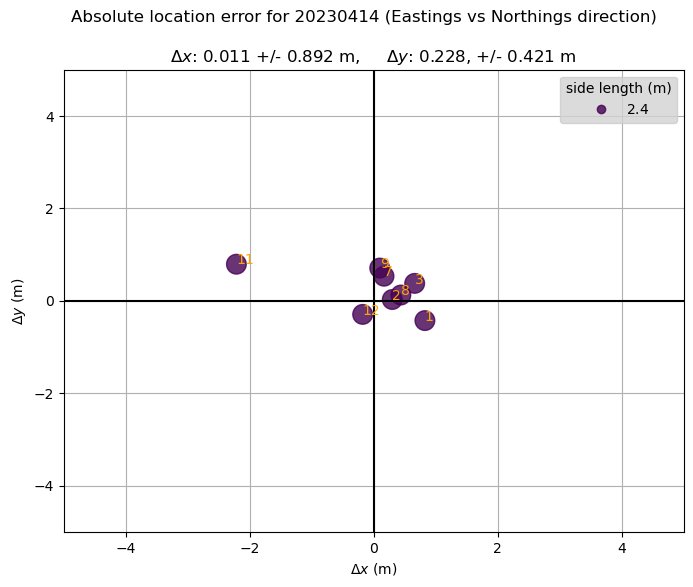

In [15]:
#plotting ALE
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(df_filter.ALE_EW, df_filter.ALE_NS, s=200, c=df_filter['slen'], alpha=0.8, marker='o')
ax.legend(*sc.legend_elements(),facecolor='lightgray')
ax.get_legend().set_title('side length (m)')
for ii, txt in enumerate(df_filter.ID):
    ax.annotate(txt, (df_filter[df_filter['ID']==txt].ALE_EW, df_filter[df_filter['ID']==txt].ALE_NS), color='orange')   #putting IDs in each CR
ax.grid(True)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set_title(f'$\Delta x$: {np.round(np.nanmean(ALE_EW), 3)} +/- {np.round(np.nanstd(ALE_EW),3)} m, \
    $\Delta y$: {np.round(np.nanmean(ALE_NS),3)}, +/- {np.round(np.nanstd(ALE_NS),3)} m')
ax.set_xlabel('$\Delta x$ (m)')
ax.set_ylabel('$\Delta y$ (m)')
fig.suptitle(f'Absolute location error for {date} (Eastings vs Northings direction)')

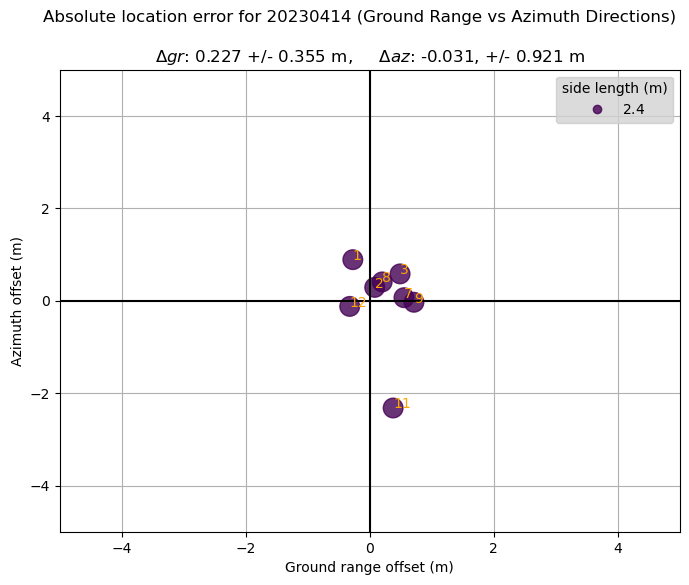

In [16]:
#plotting ALE
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(df_filter.ALE_Rg, df_filter.ALE_Az, s=200, c=df_filter['slen'], alpha=0.8, marker='o')
ax.legend(*sc.legend_elements(),facecolor='lightgray')
ax.get_legend().set_title('side length (m)')
for ii, txt in enumerate(df_filter.ID):
    ax.annotate(txt, (df_filter[df_filter['ID']==txt].ALE_Rg, df_filter[df_filter['ID']==txt].ALE_Az), color='orange')   #putting IDs in each CR
ax.grid(True)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set_title(f'$\Delta gr$: {np.round(np.nanmean(ALE_Rg), 3)} +/- {np.round(np.nanstd(ALE_Rg),3)} m, \
    $\Delta az$: {np.round(np.nanmean(ALE_Az),3)}, +/- {np.round(np.nanstd(ALE_Az),3)} m')
ax.set_xlabel('Ground range offset (m)')
ax.set_ylabel('Azimuth offset (m)')
fig.suptitle(f'Absolute location error for {date} (Ground Range vs Azimuth Directions)')
fig.savefig(f'{save_dir}/pngs/ALE_{cr_network}_{burst_id}_{date}.png',dpi=300,bbox_inches='tight')

In [17]:
# Save the summary
ALE_EW_Mean = np.round(np.nanmean(ALE_EW),3)
ALE_NS_Mean = np.round(np.nanmean(ALE_NS),3)
ALE_EW_Stdev = np.round(np.nanstd(ALE_EW),3)
ALE_NS_Stdev = np.round(np.nanstd(ALE_NS),3)
ALE_Rg_Mean = np.round(np.nanmean(ALE_Rg),3)
ALE_Az_Mean = np.round(np.nanmean(ALE_Az),3)
ALE_Rg_Stdev = np.round(np.nanstd(ALE_Rg),3)
ALE_Az_Stdev = np.round(np.nanstd(ALE_Az),3)

summary = []
summary.append([date, ALE_EW_Mean, ALE_EW_Stdev, ALE_NS_Mean, ALE_NS_Stdev, ALE_Rg_Mean, ALE_Rg_Stdev, ALE_Az_Mean, ALE_Az_Stdev])
summary_df = pd.DataFrame(summary)
summary_df.to_csv(f'{save_dir}/summary/ALE_{cr_network}.csv', mode='a', header=False)

# Save the entire dataframe to csv
df_filter.loc[:,"Date"] = [date]* len(df_filter)
df_filter.to_csv(f'{save_dir}/summary/ALE_{cr_network}_ID.csv', mode='a')

In [18]:
# End runtime evaluation
stop = timeit.default_timer()
print(f'Time: ', (stop - start)/60, 'min.')

Time:  9.593208486152191 min.
